In [ ]:
# Import libraries.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import clear_output

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

  Preparing metadata (setup.py) ... done
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset['sex'] = dataset['sex'].map({'male':0,'female':1})
dataset['smoker'] = dataset['smoker'].map({'yes':0,'no':1})
dataset['region'] = dataset['region'].map({'northwest':0,'northeast':1,'southwest':2,'southeast':3})


X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# split the dataset
train_dataset, test_dataset, train_labels, test_labels = train_test_split(
    X, y, test_size=0.20)

#train_dataset.describe()

--2024-01-22 23:04:29--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0s      

2024-01-22 23:04:29 (101 MB/s) - ‘insurance.csv’ saved [50264/50264]



In [ ]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,1,27.9,0,0,2,16884.92
1,18,0,33.8,1,1,3,1725.55
2,28,0,33.0,3,1,3,4449.46
3,33,0,22.7,0,1,0,21984.47
4,32,0,28.9,0,1,0,3866.86


In [ ]:
test_labels.describe()

count      268.000000
mean     12615.211754
std      12008.869278
min       1121.870000
25%       4534.565000
50%       8647.110000
75%      14361.027500
max      63770.430000
Name: expenses, dtype: float64

In [ ]:
cColumn = ['sex','smoker','region']
nColumn = ['age','bmi','children']
fColumns = []
for fName in cColumn:
  vocab = train_dataset[fName].unique()
  fColumns.append(tf.feature_column.categorical_column_with_vocabulary_list(fName,vocab))

for fName in nColumn:
  fColumns.append(tf.feature_column.numeric_column(fName, dtype = np.float32))

print(fColumns)

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='smoker', vocabulary_list=('no', 'yes'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='region', vocabulary_list=('southeast', 'northeast', 'southwest', 'northwest'), dtype=tf.string, default_value=-1, num_oov_buckets=0), NumericColumn(key='age', shape=(1,), default_value=None, dtype=<class 'numpy.float32'>, normalizer_fn=None), NumericColumn(key='bmi', shape=(1,), default_value=None, dtype=<class 'numpy.float32'>, normalizer_fn=None), NumericColumn(key='children', shape=(1,), default_value=None, dtype=<class 'numpy.float32'>, normalizer_fn=None)]


In [ ]:
#Input function:
def makeInputFunc(data_df,label_df,num_epochs = 5,shuffle = True, batch_size=32):
  def inptFunc():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return inptFunc

trainInptFn = makeInputFunc(train_dataset,train_labels)
testInptFn = makeInputFunc(test_dataset,test_labels,num_epochs=1,shuffle=False)


In [ ]:
#Making the model
#Linear Regression Model
# linear_reg = tf.estimator.LinearRegressor(feature_columns=fColumns)
# linear_reg.train(input_fn=trainInptFn)
# results = linear_reg.evaluate(testInptFn)

# clear_output()
# print(results)

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(np.asarray(train_dataset).astype(np.float32)))

#Deep Neural Network with numerous layers using the Sequenital model from Keras
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='gelu'),
      layers.Dense(128, activation='relu'),
      layers.Dense(256, activation='gelu'),
      layers.Dense(512, activation='gelu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

model = build_and_compile_model(normalizer)
model.summary()
history = model.fit(
    train_dataset,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_61 (Normaliz  (None, 6)                 13        
 ation)                                                          
                                                                 
 dense_98 (Dense)            (None, 64)                448       
                                                                 
 dense_99 (Dense)            (None, 128)               8320      
                                                                 
 dense_100 (Dense)           (None, 256)               33024     
                                                                 
 dense_101 (Dense)           (None, 512)               131584    
                                                                 
 dense_102 (Dense)           (None, 1)                 513       
                                                     

In [ ]:
results = model.evaluate(test_dataset, test_labels, verbose=0)
print(results)
# pd.DataFrame(results, index=['Mean absolute error [MPG]']).T

1978.8358154296875


9/9 - 0s - loss: 1978.8358 - 43ms/epoch - 5ms/step
Testing set Mean Abs Error: 1978.84 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 3ms/step


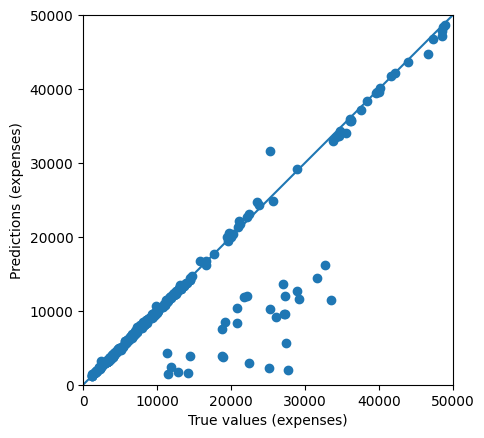

In [ ]:
# RUN THIS CELL TO TEST YOUR MODEL.
# Test model by checking how well the model generalizes using the test set.
mae = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
